In [1]:
from __future__ import print_function
import cv2
import math
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import threading
import time

## Helper fns

In [2]:
def warp(img, M):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

In [3]:
def warp_2d_coords(coords, M):
    '''
    `coords` is n-by-2.
    Math in cv2's doc for warpPerspective()
    https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
    https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective
    '''
    
    assert isinstance(coords, np.ndarray)
    num_pts, dim = coords.shape
    assert dim == 2
    
    coords_augmented = np.append(
        coords,
        np.ones([num_pts, 1]),
        axis=1
    )
    temp = np.dot(coords_augmented, M.T)
    
    return np.divide(
        temp[:, :2],
        temp[:, 2, np.newaxis]
    )

## TODO Calibrate with chessboard

## Warp to birds-eye view

In [4]:
def warp_to_birdseye(img,
                     src_deep_y, src_deep_l, src_deep_r,
                     src_shallow_y, src_shallow_l, src_shallow_r,
                     rect_h_meter, rect_w_meter, rect_to_ego_meter):
    '''
    Args `src_deep_*`: define the distal horizontal line of the pre-warped trapezoid.
    Args `src_shallow_*`: ditto the proximal line.
    Args `rect_h_meter`, `rect_w_meter`: real-life size of the post-warped rectangle.
    Arg `rect_to_ego_meter`: real-life distance between camera's vertical position and
        the proximal line of the post-warped rectangle.
    
    Note, the horizontal lines of pre-warped trapezoid and post-warped rectangle may not exactly match
        landmarks in real life, if the approach angle was not straight.
    But transformation can still be adjusted s.t. the post-warped dimension is not skewed.
    '''
    
    h, w, _ = img.shape
    
    src_trapezoid = np.float32([
        [src_deep_l, src_deep_y],
        [src_deep_r, src_deep_y],
        [src_shallow_r, src_shallow_y],
        [src_shallow_l, src_shallow_y]
    ])
    
    def dest():
        top = min(h * 0.1, src_deep_y)
        
        meter_to_pixel_ratio = (h - top) / (rect_h_meter + rect_to_ego_meter)
        
        rect_h = rect_h_meter * meter_to_pixel_ratio
        rect_w = rect_w_meter * meter_to_pixel_ratio
        
        btm = top + rect_h
        left = (w - rect_w) / 2
        right = w - left
        
        return (
            np.float32([
                [left, top],
                [right, top],
                [right, btm],
                [left, btm]
            ]),
            1 / meter_to_pixel_ratio
        )
        
    dest_rect, pixel_to_meter_ratio = dest()
    
    M = cv2.getPerspectiveTransform(src_trapezoid, dest_rect)
    
    plottable_src_trapezoid = np.append(src_trapezoid, src_trapezoid[:1], axis=0)
    plottable_dest_rect = np.append(dest_rect, dest_rect[:1], axis=0)
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax0.imshow(img)
    ax0.plot(plottable_src_trapezoid[:, 0], plottable_src_trapezoid[:, 1], 'r')
    ax0.set_title('Undistorted')
    
    ax1.imshow(warp(img, M))
    ax1.plot(plottable_dest_rect[:, 0], plottable_dest_rect[:, 1], 'r')
    ax1.set_title('Warped')
    
    return M, pixel_to_meter_ratio

<IPython.core.display.Javascript object>


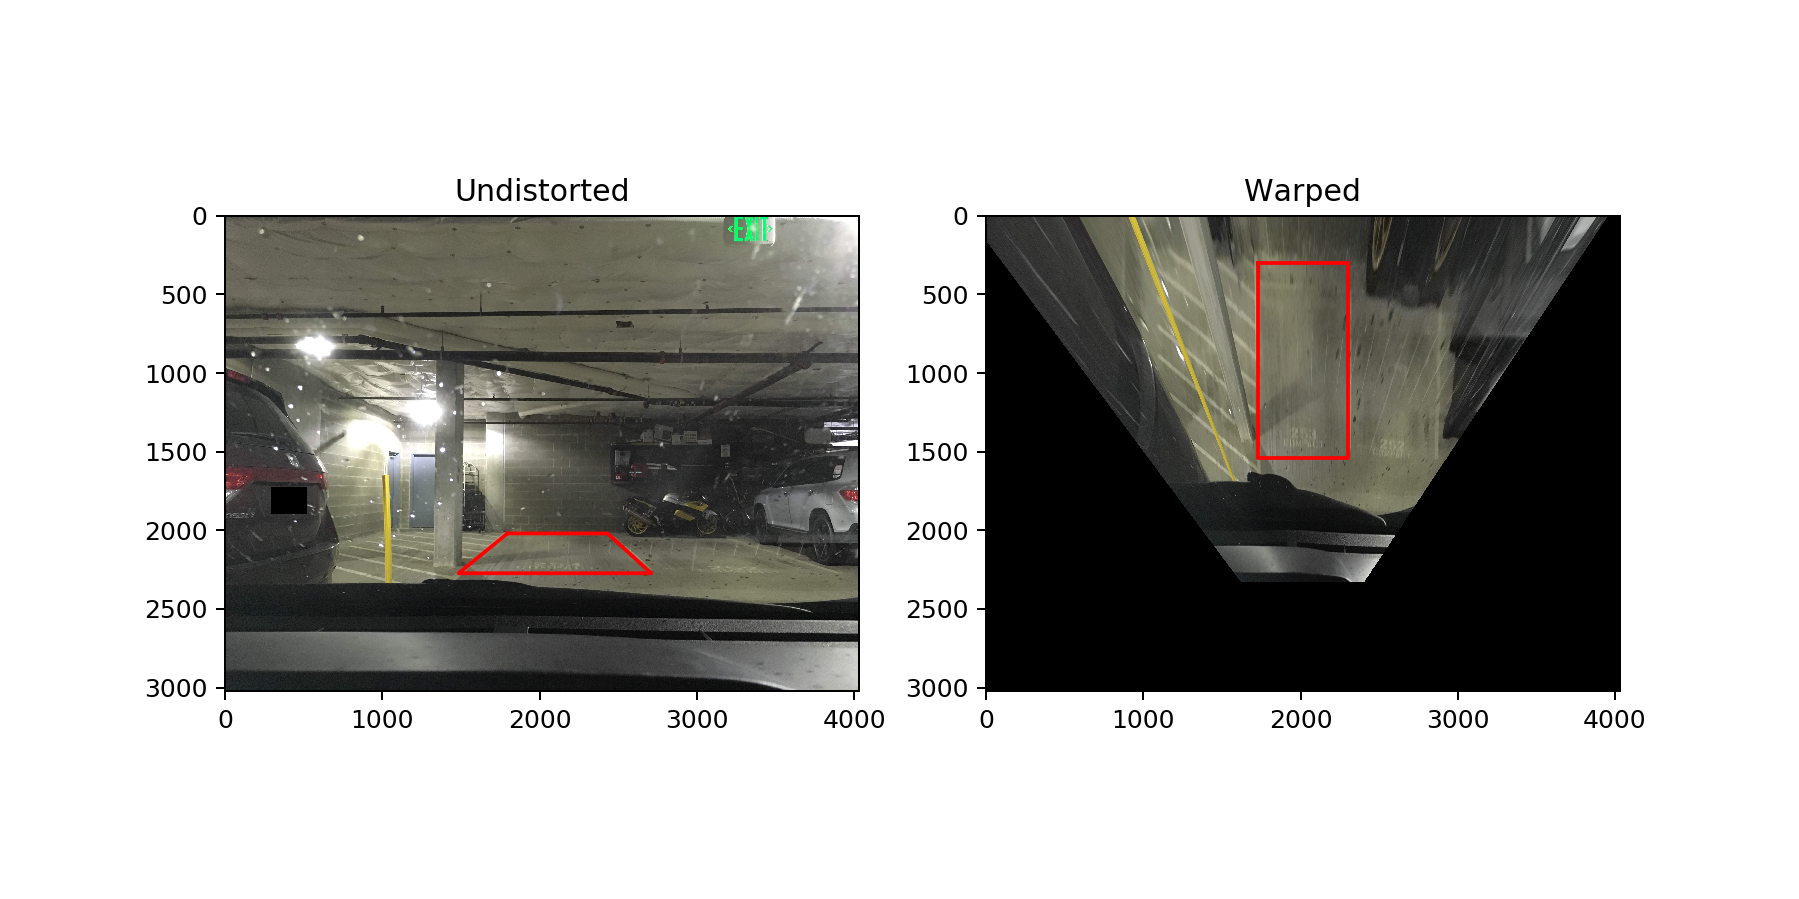

In [5]:
## Guess and adjust these values here.

# WARPER_MATRIX, PIXEL_TO_METER_RATIO = warp_to_birdseye(
#     cv2.imread('sample_data/indoor0/angle-calibration.jpg')[..., ::-1],
#     800, 1120, 2640,
#     2155, 325, 3672,
#     72 / 39.37008, 48 / 39.37008, 1     # 39.37008 converts inches to meters
# )

WARPER_MATRIX, PIXEL_TO_METER_RATIO = warp_to_birdseye(
    cv2.imread('sample_data/prius-c-dash/angle-calibration.jpg')[..., ::-1],
    2020, 1795, 2432,
    2273, 1485, 2710,
    5.92, 2.75, 7.07
)

## Define some parameters for the rest of the code

In [75]:
### If running this live, download img from mobile.

# PARKING_IMG_PATH = 'sample_data/indoor0/mock-parking-spot0.jpg'
# PARKING_IMG_PATH = 'sample_data/prius-c-dash/parking0.jpg'
# PARKING_IMG_PATH = 'sample_data/prius-c-dash/parking1.jpg'
PARKING_IMG_PATH = 'sample_data/prius-c-dash/parking2.jpg'

In [39]:
def define_ego_measurements():
    mock_indoor_measurements = {
        'wheelbase': 2.0,
        'turning_radius': 3.0,
        'length': 5.0,
        'width': 1.2
    }

    prius_c_measurements = {
        'wheelbase': 2.550,
        'turning_radius': 4.084,
        'length': 4.000,
        'width': 1.690,
        'max_steeringwheel_deg': 550
    }
    
    return prius_c_measurements

EGO_MEASUREMENTS = define_ego_measurements()

In [40]:
# Granularity at which the path finding algorithm should search.
METERS_PER_GRID_CELL = 0.1

## Annotate parking spot and obstacles

<IPython.core.display.Javascript object>


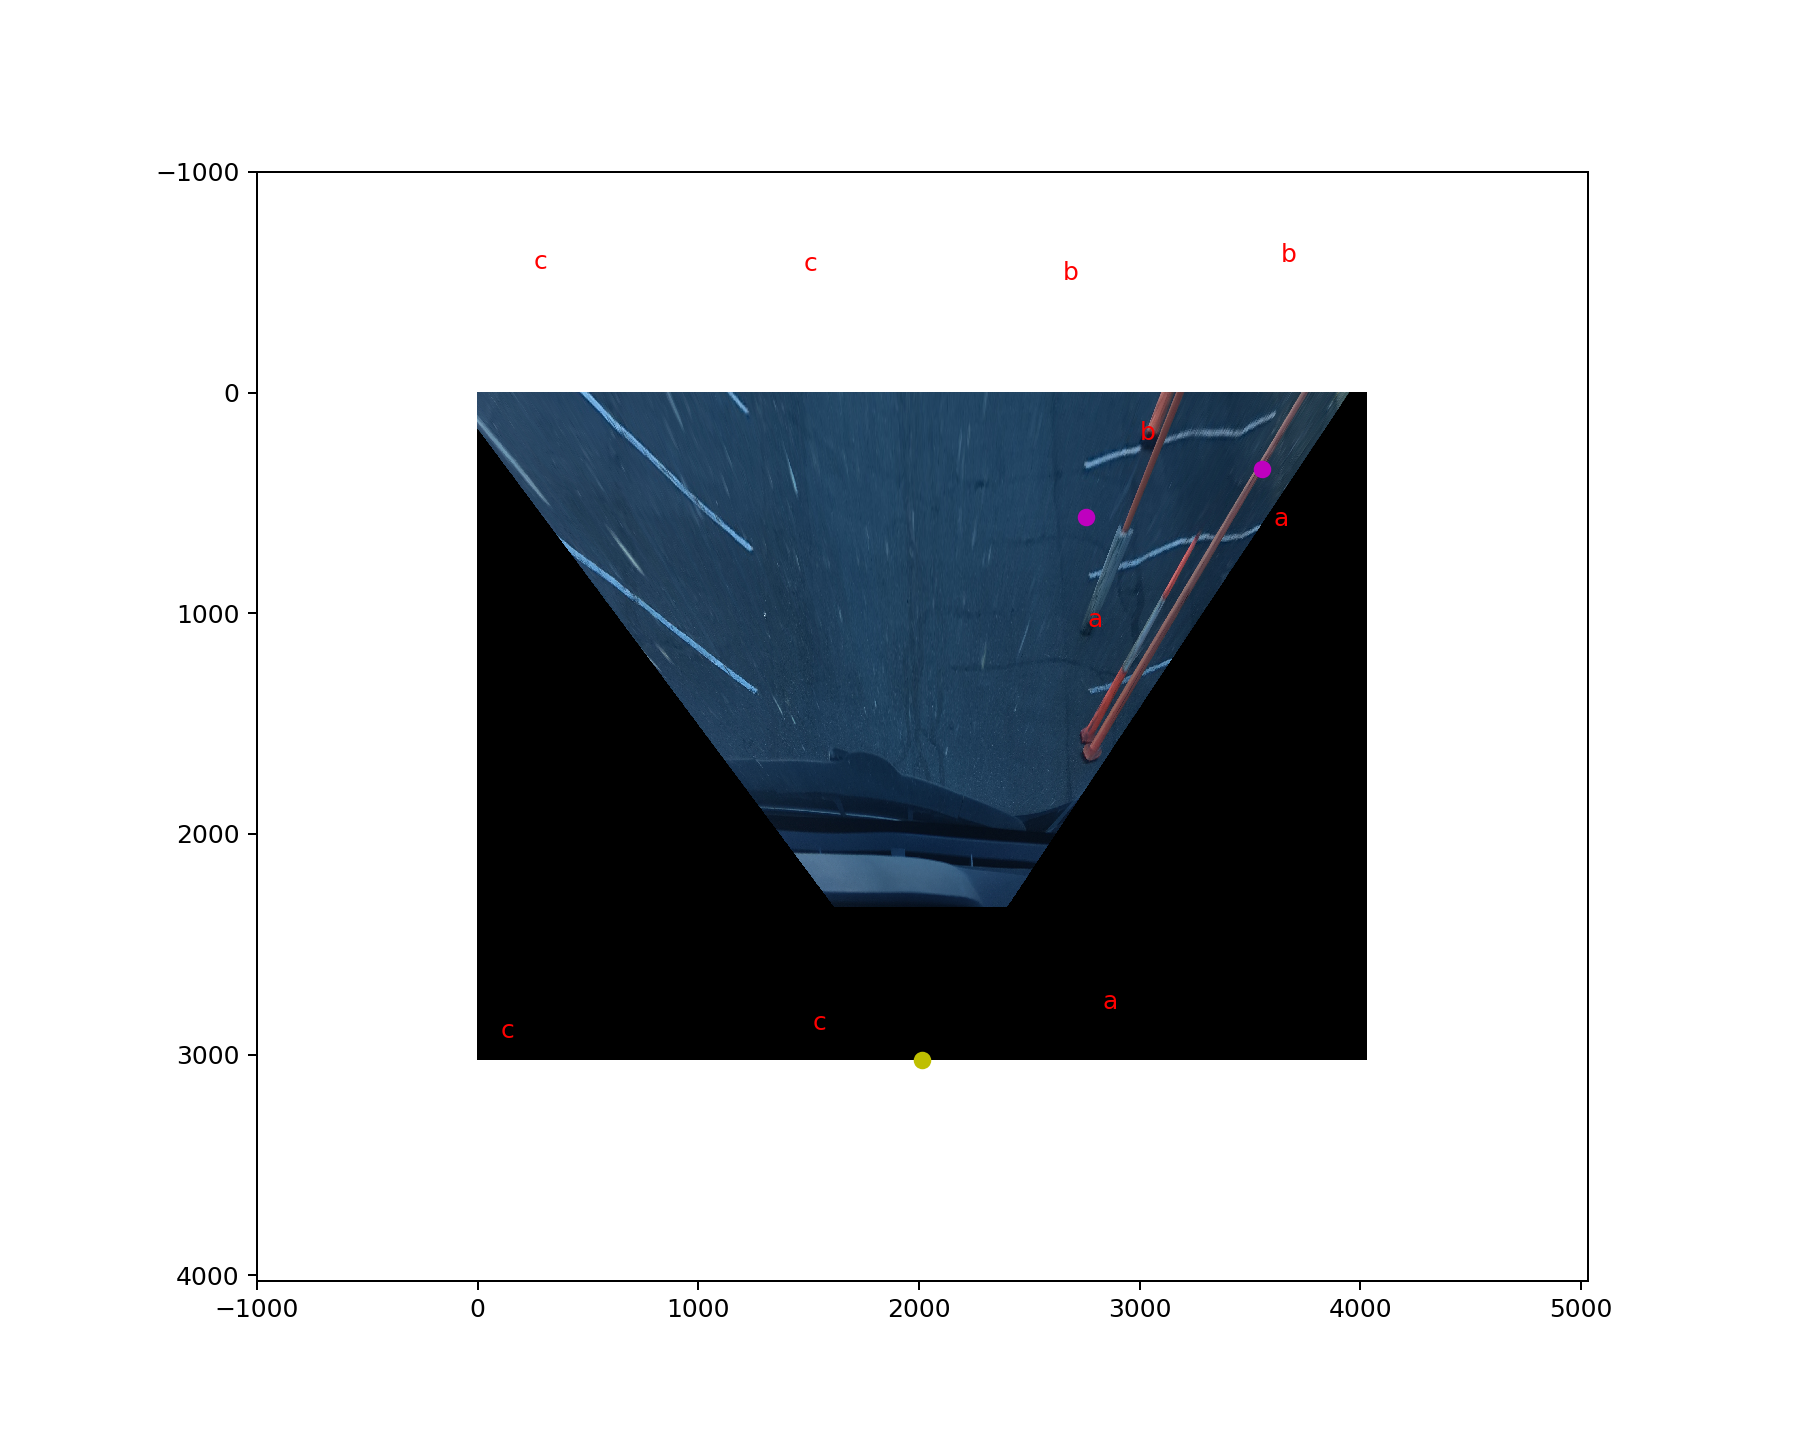

In [126]:
def choose_coords_on_birdseye_img(img_path):
    '''
    Interactively choose boundaries of the parking spot and any obstacles.
    Usage:
    - While not holding down any key, right click boundaries of the parking spot.
      These points are just for visual guidance, and are discarded.
    - While holding down 'p' key, right click at exactly two locations, in this order:
        1) The center of the rear bumper at the parked position
        2) The center of the front bumper at the parked position
    - While holding down a key, left click corners of obstacles.
      The key identifies a unique obstacle.
      Make sure there are at least 3 coords per obstacle.

    When you're done, move on to the next notebook cell.
    
    In case of any mistake, redo by running this cell.
    
    In the returned object, all coordinates are (x,y), NOT (y,x).
    '''
    
    parking_coords = []
    obstacle_coords = {}
    last_pressed_key_ptr = [None]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def mouse_callback(event):
        if event.xdata is None or event.ydata is None:
            # Either being None means an event out side the image.
            return
        
        if event.button == 3:
            # right click
            if last_pressed_key_ptr[0] == 'p':
                parking_coords.append((event.xdata, event.ydata))
                ax.plot(event.xdata, event.ydata, 'om')
            else:
                ax.plot(event.xdata, event.ydata, 'ob')
        else:
            char = last_pressed_key_ptr[0] or 'x'
            coords = obstacle_coords.get(char, [])
            obstacle_coords[char] = coords
            coords.append((event.xdata, event.ydata))
            ax.text(event.xdata, event.ydata, char, color='red')
    fig.canvas.callbacks.connect('button_press_event', mouse_callback)

    def kbd_press_callback(event):
        last_pressed_key_ptr[0] = event.key
    fig.canvas.callbacks.connect('key_press_event', kbd_press_callback)
    def kbd_release_callback(event):
        last_pressed_key_ptr[0] = None
    fig.canvas.callbacks.connect('key_release_event', kbd_release_callback)

    img = cv2.imread(img_path)[..., ::-1]
    ax.imshow(warp(img, WARPER_MATRIX))
    ax.set_xlim(-1000, img.shape[1] + 1000)
    ax.set_ylim(img.shape[0] + 1000, -1000)
    
    # Unwarping was previously done s.t. the bottom center is the camera.
    # Approximate ego's position using the camera's position,
    #     though ideally ego's position should be at the rear axle.
    ego_coord = [
        img.shape[1] / 2,
        img.shape[0]
    ]
    ax.plot(ego_coord[0], ego_coord[1], 'oy')
    
    return {
        'ego': ego_coord,
        'parking': parking_coords,
        'obstacles': obstacle_coords
    }

BIRDSEYE_PX_COORDS = choose_coords_on_birdseye_img(PARKING_IMG_PATH)

In [127]:
assert len(BIRDSEYE_PX_COORDS['parking']) == 2, 'Need exactly 2 points for parking.'
for key, coords_for_key in BIRDSEYE_PX_COORDS['obstacles'].items():
    assert len(coords_for_key) >= 3, 'Need 3 or more points per obstacle region.'

In [128]:
def px_coords_to_relative_meters(px_coords, pixel_to_meter_ratio):
    '''
    Input `px_coords` are in pixels, and the origin is top-left.
    Output coords are in meters, and the origin is at ego.
    For both the input and the output, x increases towards right, y increases towards bottom.
    '''
    
    ego_x, ego_y = px_coords['ego']
    
    def convert_one(x, y):
        return (
            (x - ego_x) * pixel_to_meter_ratio,
            (y - ego_y) * pixel_to_meter_ratio
        )
    
    relative_meter_coords = {
        'parking': [
            convert_one(x, y)
            for x, y in px_coords['parking']
        ],
        'obstacles': {
            key: [
                convert_one(x, y)
                for x, y in coords_for_key
            ]
            for key, coords_for_key in px_coords['obstacles'].items()
        }
    }
    
    return relative_meter_coords

RELATIVE_METER_COORDS = px_coords_to_relative_meters(
    BIRDSEYE_PX_COORDS,
    PIXEL_TO_METER_RATIO
)

In [129]:
def visualize_relative_meter_coords(ax, relative_meter_coords):
    
    # Initialize min and max coords to be 0 in order to include (0meter, 0meter) coord in the grid.
    bounds = {
        'min_x': 0,
        'min_y': 0,
        'max_x': 0,
        'max_y': 0
    }
    
    def update_bounds(x, y):
        bounds['min_x'] = min(bounds['min_x'], x)
        bounds['max_x'] = max(bounds['max_x'], x)
        bounds['min_y'] = min(bounds['min_y'], y)
        bounds['max_y'] = max(bounds['max_y'], y)
    
    for x, y in relative_meter_coords['parking']:
        ax.plot(x, y, 'om')
        update_bounds(x, y)
    
    obst_polygon_paths = []
    obst_polygons = []
    for key, coords_for_key in relative_meter_coords['obstacles'].items():
        for x, y in coords_for_key:
            ax.text(x, y, key, color='red')
            update_bounds(x, y)
        
        coords_for_key = np.array(coords_for_key)
        
        polygon_path = mplPath.Path(coords_for_key)
        obst_polygon_paths.append(polygon_path)
        
        obst_polygons.append(Polygon(coords_for_key, True))
            
    obst_patch_colln = PatchCollection(obst_polygons, alpha=0.4)
    ax.add_collection(obst_patch_colln)

    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Need to set limits in order to show obstacles
    ax.set_xlim(bounds['min_x'], bounds['max_x'])
    ax.set_ylim(bounds['min_y'], bounds['max_y'])
    ax.invert_yaxis()
    ax.axis('equal')
    
    return bounds, obst_polygon_paths, obst_patch_colln

<IPython.core.display.Javascript object>


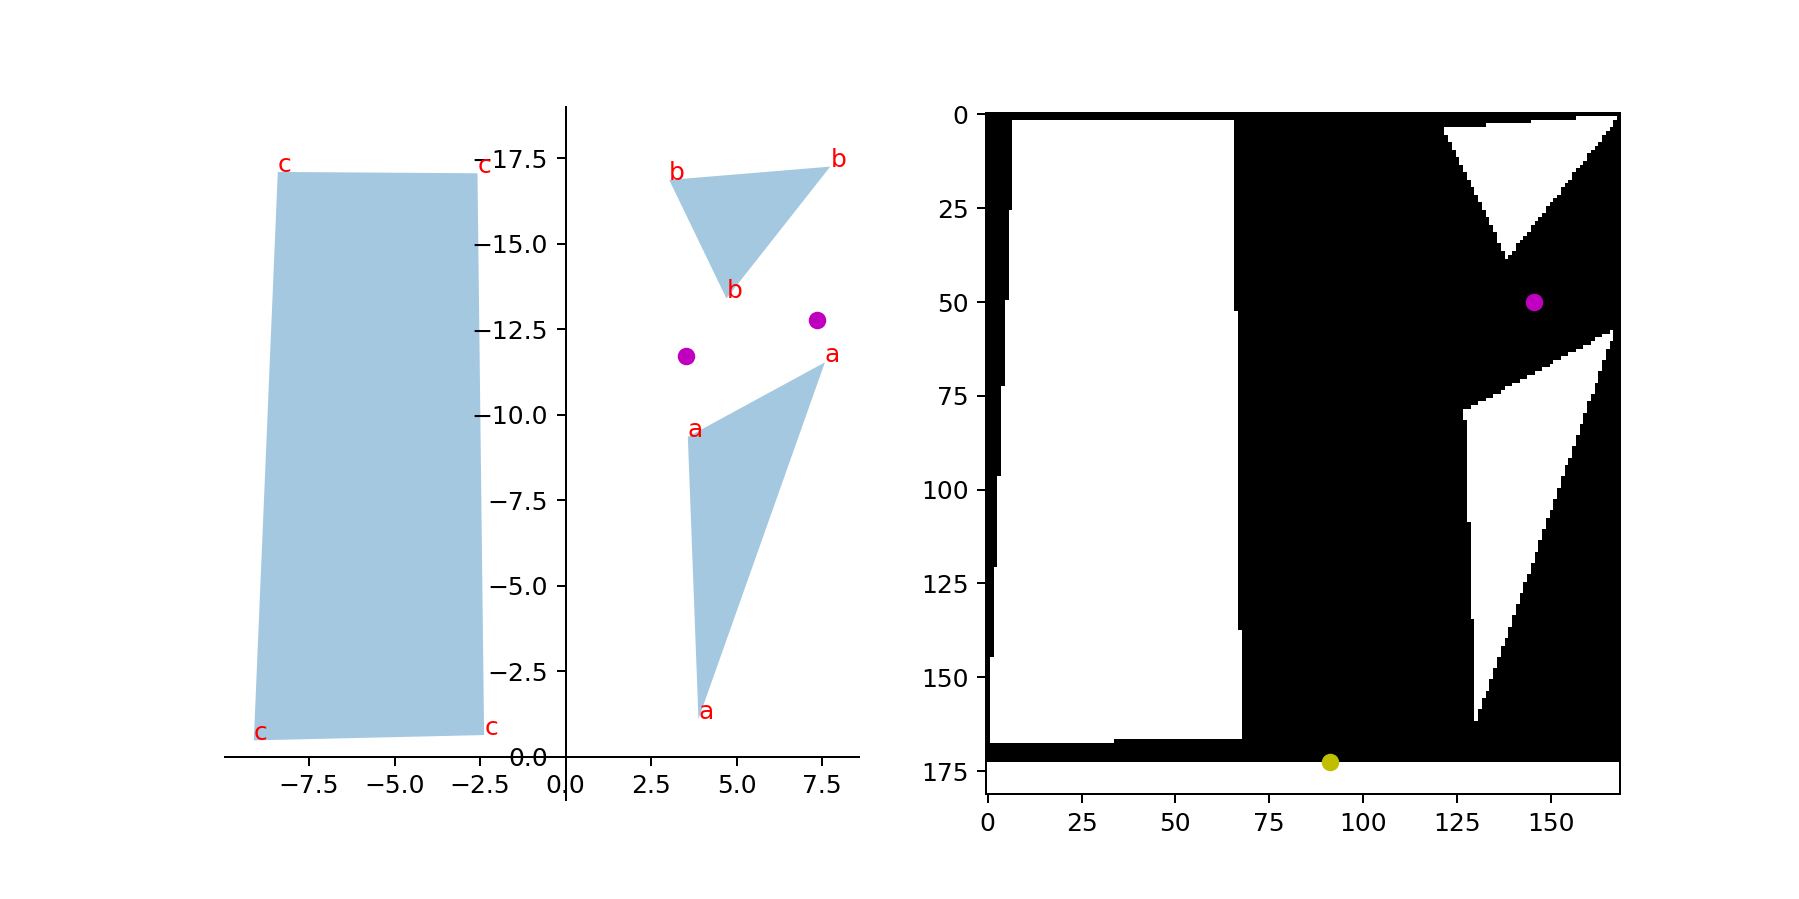

In [130]:
def generate_grid(relative_meter_coords, meters_per_grid_cell):
    
    fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

    bounds, obst_polygon_paths, obst_patch_colln = \
        visualize_relative_meter_coords(ax, relative_meter_coords)
    
    ###
    
    ys = np.arange(bounds['min_y'], bounds['max_y'], meters_per_grid_cell)
    xs = np.arange(bounds['min_x'], bounds['max_x'], meters_per_grid_cell)
    obstacles_grid = np.zeros([len(ys), len(xs)], dtype=np.bool)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            obstacles_grid[i, j] = any(path.contains_point((x, y)) for path in obst_polygon_paths)
    ax1.imshow(obstacles_grid, cmap='Greys_r')
        
    ego_coord_grid = [-bounds['min_x'] / meters_per_grid_cell, -bounds['min_y'] / meters_per_grid_cell]
    ax1.plot(ego_coord_grid[0], ego_coord_grid[1], 'oy')
    
    parking_center_coord_meter = [(a + b) / 2 for a, b in zip(* relative_meter_coords['parking'])]
    parking_center_coord_grid = [(val - ref) / meters_per_grid_cell
                                 for val, ref in zip(
                                     parking_center_coord_meter,
                                     [bounds['min_x'], bounds['min_y']]
                                 )]
    ax1.plot(parking_center_coord_grid[0], parking_center_coord_grid[1], 'om')
    
    # The parking points are 0) rear 1) front. Calculate front minus rear.
    delta_parking_x, delta_parking_y = (b - a for a, b in zip(* relative_meter_coords['parking']))
    parking_theta = np.arctan2(delta_parking_y, delta_parking_x)

    ###
    
    obstacles_grid_info = {
        'min_x_meter': bounds['min_x'],
        'min_y_meter': bounds['min_y'],
        'ego_coord_grid': ego_coord_grid,
        'parking_center_coord_meter': parking_center_coord_meter,
        'parking_center_coord_grid': parking_center_coord_grid,
        'parking_theta': parking_theta
    }
    
    return obstacles_grid, obstacles_grid_info

OBSTACLES_GRID, OBSTACLES_GRID_INFO = generate_grid(RELATIVE_METER_COORDS, METERS_PER_GRID_CELL)

## Derive path

In [14]:
# TODO use cython rather than filesystem and stdout as the media of communication

In [131]:
with open('grid.txt', 'w') as file:
    for i in range(OBSTACLES_GRID.shape[0]):
        file.write(str(int(OBSTACLES_GRID[i, 0])))
        for j in range(1, OBSTACLES_GRID.shape[1]):
            file.write(str(int(OBSTACLES_GRID[i, j])))
        file.write('\n')

In [132]:
def parse_derived_path(output):
    return [
        [float(n_str) for n_str in row.split(',')]
        for row in output
    ]

def derive_path(ego_measurements):
    exec_path = 'hybrid-a-star/cmake-build-debug/hybrid_a_star'

    start_x, start_y = OBSTACLES_GRID_INFO['ego_coord_grid']
    start_theta = math.pi / -2 # pointing up in the grid
    goal_x, goal_y = OBSTACLES_GRID_INFO['parking_center_coord_grid']
    goal_theta = OBSTACLES_GRID_INFO['parking_theta']
    
    float_args = ' '.join(str(foo) for foo in [
        start_x, start_y, start_theta,
        goal_x, goal_y, goal_theta
    ] + [ego_measurements[key] for key in ['wheelbase', 'turning_radius', 'length', 'width']])

    stdout = ! $exec_path grid.txt $float_args
    
    try:
        return parse_derived_path(stdout)
    except Exception as e:
        for line in stdout:
            print(line)
        print('derive_path error:')
        print(e)

PATH_STATES = derive_path(EGO_MEASUREMENTS)

<IPython.core.display.Javascript object>


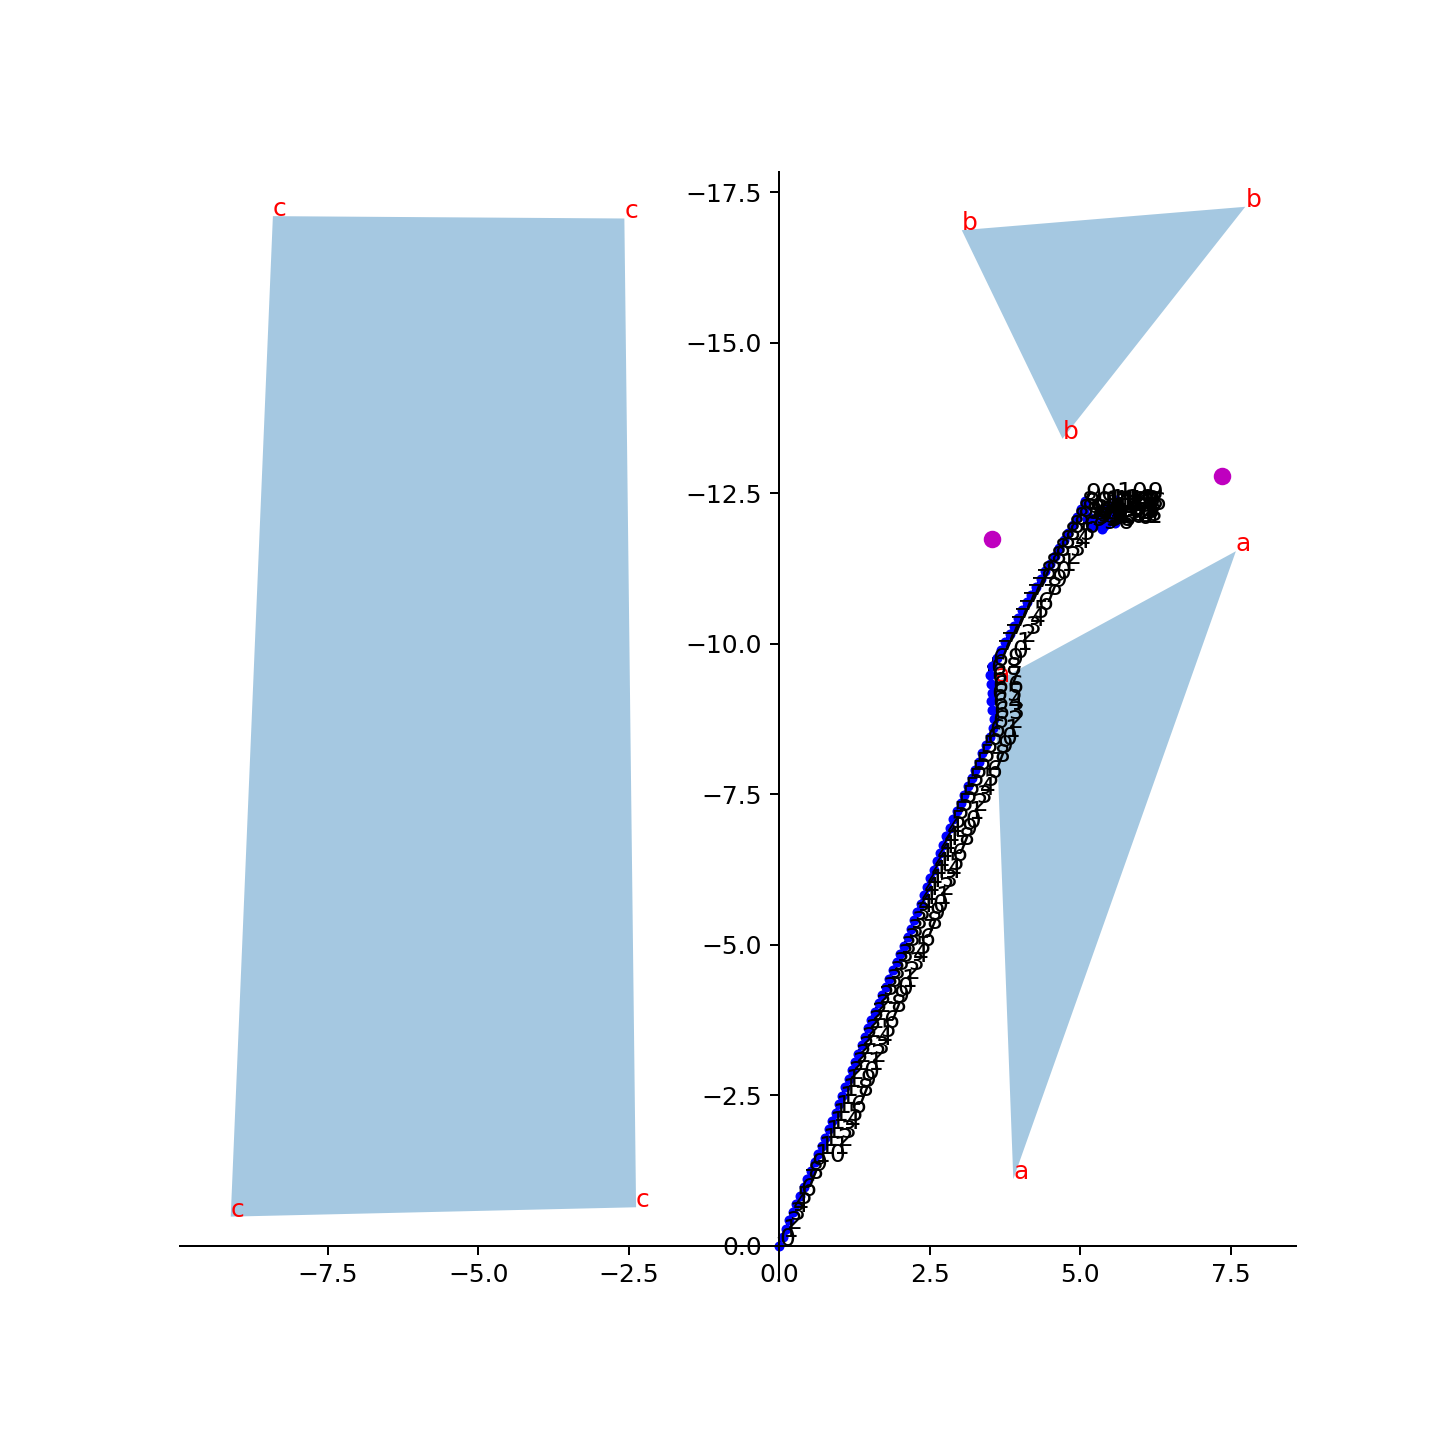

In [133]:
def plot_path(path_states, obstacles_grid_info, relative_meter_coords):
    min_x_meter = obstacles_grid_info['min_x_meter']
    min_y_meter = obstacles_grid_info['min_y_meter']
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    visualize_relative_meter_coords(ax, relative_meter_coords)
    
    ###
    
    arrow_len = 1.45
    arrow_len *= METERS_PER_GRID_CELL
    for i, state in enumerate(path_states):
        x, y, theta = state[:3]

        x_meter, y_meter = [n * METERS_PER_GRID_CELL + ref
                            for n, ref in zip([x, y], [min_x_meter, min_y_meter])]
        
        ax.plot(x_meter, y_meter, '.b')
        ax.text(x_meter, y_meter, i)
        ax.arrow(x_meter, y_meter, arrow_len * math.cos(theta), arrow_len * math.sin(theta))
    
    def plot_ego_position(x, y):
        ax.plot(x, y, '.y')
    return plot_ego_position
    
PLOT_EGO_POSITION = plot_path(PATH_STATES, OBSTACLES_GRID_INFO, RELATIVE_METER_COORDS)

## Feed live metric

In [115]:
def create_ego_tracker(ego_measurements, plot_ego_position):
    wheelbase = ego_measurements['wheelbase']
    
    ego = {
        'x': 0,
        'y': 0,
        'theta': -(math.pi / 2)
    }
    prev_time_ptr = [None]
    
    def receive_speed_and_angle(speed, angle, gear_multiplier):
        time_now = time.time()
        
        if prev_time_ptr[0] is None:
            prev_time_ptr[0] = time_now
            return
        
        delta_time = time_now - prev_time_ptr[0]
        dist = delta_time * speed * gear_multiplier
        delta_theta = math.tan(angle) * dist / wheelbase

        ego['theta'] = ego['theta'] + delta_theta
        ego['x'] = ego['x'] + dist * math.cos(ego['theta'])
        ego['y'] = ego['y'] + dist * math.sin(ego['theta'])
        
        plot_ego_position(ego['x'], ego['y'])
        
        prev_time_ptr[0] = time_now
    return receive_speed_and_angle
    
RECEIVE_SPEED_AND_ANGLE = create_ego_tracker(EGO_MEASUREMENTS, PLOT_EGO_POSITION)

#### Panda

In [111]:
from panda import Panda

In [116]:
def start_listening_by_panda(ego_measurements, receive_speed_and_angle):
    max_steering_on_ground_rad = math.atan2(ego_measurements['wheelbase'], ego_measurements['turning_radius'])
    max_steeringwheel_deg = ego_measurements['max_steeringwheel_deg']
    
    def byte_array_to_int(byte_array):
        result = 0
        for i, b in enumerate(reversed(byte_array)):
            result += pow(256, i) * b
        return result
    
    def parse_speed(data_str):
        bytes = [ord(c) for c in data_str[5:7]]
        speed = byte_array_to_int(bytes) * 0.01 # km/h
        speed *= 1000. / 3600 # m/s
        return speed
        
    def parse_angle(data_str):
        bytes = [ord(c) for c in data_str[:2]]
        steering_wheel_deg = byte_array_to_int(bytes)
        if (1 << 11) & steering_wheel_deg:
            steering_wheel_deg -= (1 << 12)
        steering_wheel_deg = steering_wheel_deg * 1.5 # deg
        
        # Assuming linear rack-n-pinion. Ignore non-linear rubber on tires.
        steering_on_ground_rad = steering_wheel_deg / max_steeringwheel_deg * max_steering_on_ground_rad
        return steering_on_ground_rad
    
    def parse_gear_multiplier(data_str):
        if ord(data_str[5]) >> 4 == 1: # Reverse. Values from 0 to 4 are [P, R, N, D, B].
            return -1
        return 1

    # 0: speed
    # 1: angle
    # 2: gear multiplier
    values_from_panda = [None, None, None]
    
    thread_killer = threading.Event()
    def stop_panda():
        thread_killer.set()
        print('Stopped listening to panda.')
        
    def panda_listener():
        '''
        Sleeping in betweeing `can_recv()` causes panda to hang.
        So listen from panda continuously, and publish the result to memory, and some other threads can read that.
        '''
        
        panda_inst = Panda(serial='WIFI')
        try:
            while not thread_killer.is_set():
                for addr, _, dat, src in panda_inst.can_recv():
                    # Define callbacks in the desc order of frequency of the messages.
                    if addr == 0xb4:
                        values_from_panda[0] = parse_speed(dat)
                    elif addr == 0x25:
                        # Invert sign b/c the plot's y-axis is inverted.
                        values_from_panda[1] = -parse_angle(dat)
                    elif addr == 0x127:
                        values_from_panda[2] = parse_gear_multiplier(dat)
        finally:
            panda_inst.close()
            print('thread listening to panda is closed')
    threading.Thread(target=panda_listener).start()
    
    def speed_and_angle_publisher():
        interval = 0.5 # sec
        while not thread_killer.is_set() and any(v is None for v in values_from_panda):
            print('waiting.')
            thread_killer.wait(interval)
        print('connected.')
        while not thread_killer.is_set():
            receive_speed_and_angle(*values_from_panda)
            thread_killer.wait(interval)
        print('thread publishing to plot is done')
    threading.Thread(target=speed_and_angle_publisher).start()
    
    return stop_panda

STOP_PANDA = start_listening_by_panda(EGO_MEASUREMENTS, RECEIVE_SPEED_AND_ANGLE)

print('''
Now scroll back up to the plot with the derived path.
Your position should be reflected live. Clicking on the plot.
Clicking on the plot seems to prompt its refreshing lol.
To restart, rerun all cells from the one containing `def plot_path`.''')

waiting.
Now scroll back up to the plot with the derived path.
Your position should be reflected live. Clicking on the plot.
Clicking on the plot seems to prompt its refreshing lol.
To restart, rerun all cells from the one containing `def plot_path`.

opening WIFI device
connected
connected.


In [117]:
STOP_PANDA()

Stopped listening to panda.
thread listening to panda is closed


#### Simulated can bus feed

In [24]:
def publish_simulated_bus_feed(receive_speed_and_angle):
#     def dy_dx(x):
#         return 3 * pow(x - 1, 2)
#     def d2y_dx2(x):
#         return 6 * (x - 1)

    def dy_dx(x):
        return 2 * x
    def d2y_dx2(x):
        return 2
    
    speed = 1.2 # m/s
    x = 0
    
    t_interval = 0.5
    for t in np.arange(0, 12, t_interval):
        dx = speed * math.cos(dy_dx(x))
        x += dx
        
        change_in_angle = math.atan(d2y_dx2(x) * dx)
        
        print(speed, change_in_angle)
        receive_speed_and_angle(speed, change_in_angle)
        
        time.sleep(t_interval)
    
    print('done')
    
threading.Thread(target=publish_simulated_bus_feed, args=(RECEIVE_SPEED_AND_ANGLE,)).start()

1.2 1.1760052071
1.2 -1.05646947203
1.2 1.09462434413
1.2 -1.11060588733
1.2 1.11576835032
1.2 -1.11716004279
1.2 1.11750761768
1.2 -1.1175924767
1.2 1.11761307438
1.2 -1.11761806686
1.2 1.11761927653
1.2 -1.1176195696
1.2 1.1176196406
1.2 -1.11761965781
1.2 1.11761966197
1.2 -1.11761966298
1.2 1.11761966323
1.2 -1.11761966329
1.2 1.1176196633
1.2 -1.1176196633
1.2 1.11761966331
1.2 -1.11761966331
1.2 1.11761966331
1.2 -1.11761966331
done
